# SETUP

In [20]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import nltk
import seaborn as sns
from matplotlib import pyplot as plt
sns.set() 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_score, recall_score, accuracy_score


In [2]:
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data: load / explore

In [3]:
df = pd.read_csv('data/trials.csv')
df.shape

(1759, 3)

In [4]:
df.head().T

,0,1,2,3,4
nctid,NCT02464748,NCT00362362,NCT03154450,NCT03487263,NCT04454892
description,MND is often referred to as amyotrophic latera...,OBJECTIVE:||The causes of sporadic motor neuro...,Non-invasive ventilation (NIV) use in patients...,The objectives of this study are to determine:...,"With the development of supportive measures, t..."
label,ALS,ALS,ALS,ALS,ALS


#### Verify that the sizes of the groups are the same as in the task description

In [5]:
df.groupby('label').count()

,nctid,description
label,,
ALS,368,368
Dementia,368,368
Obsessive Compulsive Disorder,358,358
Parkinson’s Disease,330,330
Scoliosis,335,335


In [6]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')


#### Looking at sentence and word numbers to find descriptions that won't be informative enough to classify

In [7]:
def processDesc(desc):
    '''clean up special (paragraph?) characters for sentence parsing'''
    return desc.replace('||', ' ')

df['num_sents'] = df['description'].apply(lambda x: len(nltk.sent_tokenize(processDesc(x))))
df['num_words'] = df['description'].apply(lambda x: len(tokenizer.tokenize(x)))


(1759, 5)

In [39]:
## sentence length doesn't flag up anomalies well
df[df['num_sents'] == 1]['description']

0       MND is often referred to as amyotrophic latera...
7       The National ALS Registry's Research Notificat...
33      The objective of this research is to pursue po...
35      Phase 2/3 trial in ALS patients Double-blinded...
57      Open Safety and Tolerability study to evaluate...
                              ...                        
1728    As secondary objective, the study aims to stud...
1729    As secondary objectives, the study aims:||to e...
1732    Aim 1: To identify genetic variants in selecte...
1739    Design: Prospective study|Inclusion criteria o...
1746    This is a prospective multi-center, noninterve...
Name: description, Length: 92, dtype: object

In [38]:
## very short descriptions can highlight lack of information about the study
df[df['num_words'] < 20]['description']

0       MND is often referred to as amyotrophic latera...
7       The National ALS Registry's Research Notificat...
127      This study is an extension study of NCT03626012.
192                There is no more extensive information
305     Phase II open labeled trial testing the effica...
350     Screening of up to 4 weeks Treatment of up to ...
365     Due to limited participation, this study has c...
406                    See Brief Summary for description.
448                                             see above
520     Written consent form. Completing ICBT in our p...
541     Please see the brief summary for study descrip...
877     This case -control observational prospective s...
944     We are studying & researching the effect of Cr...
985                              no extensive description
1019    Multinational, multicenter, randomized, parall...
1097    Outcome measures were what subjects wanted if ...
1355    Design:||Cluster-randomized controlled trial w...
1440    screw 

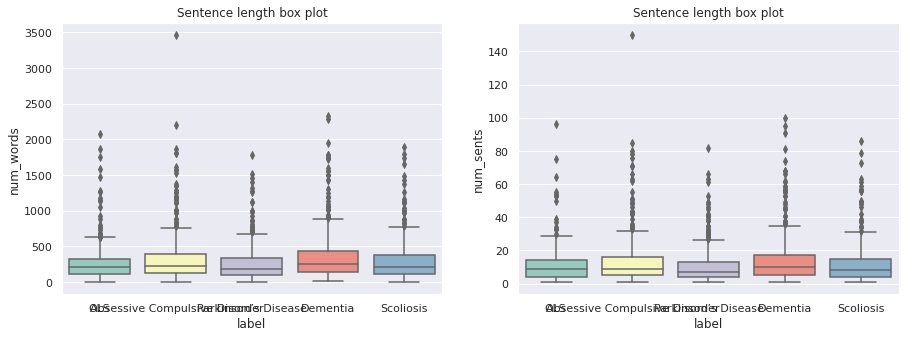

In [34]:
fig, axes = plt.subplots(1, 2,figsize=(15,5))
ax = sns.boxplot(x="label", y="num_words", data=df, palette="Set3", ax=axes[0]).set_title('Sentence length box plot')
ax = sns.boxplot(x="label", y="num_sents", data=df, palette="Set3", ax=axes[1]).set_title('Sentence length box plot')


## features...

In [41]:

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, ngram_range=(1, 3), stop_words='english').fit(df.description)
pickle.dump(tfidf, open("tfidf-descriptions.pkl", "wb"))

features = tfidf.transform(df.description).toarray()
labels = df.label.to_numpy()
print(f'feature of size {features.shape[1]}')

feature of size 55397


In [6]:

N = 3
for condition in np.unique(labels): 
  features_chi2 = chi2(features, labels == condition)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print(condition)
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
  print("  * Most Correlated Trigrams are: %s" %(', '.join(trigrams[-N:])))

ALS
  * Most Correlated Unigrams are: amyotrophic, sclerosis, als
  * Most Correlated Bigrams are: als patients, amyotrophic lateral, lateral sclerosis
  * Most Correlated Trigrams are: functional rating scale, lateral sclerosis als, amyotrophic lateral sclerosis
Dementia
  * Most Correlated Unigrams are: caregiver, caregivers, dementia
  * Most Correlated Bigrams are: patients dementia, alzheimer disease, people dementia
  * Most Correlated Trigrams are: alzheimer disease related, alzheimer disease ad, long term care
Obsessive Compulsive Disorder
  * Most Correlated Unigrams are: obsessive, compulsive, ocd
  * Most Correlated Bigrams are: disorder ocd, compulsive disorder, obsessive compulsive
  * Most Correlated Trigrams are: obsessive compulsive scale, compulsive disorder ocd, obsessive compulsive disorder
Parkinson’s Disease
  * Most Correlated Unigrams are: levodopa, parkinson, pd
  * Most Correlated Bigrams are: pd patients, disease pd, parkinson disease
  * Most Correlated Trigr

#### All n-gram words with high correlations to their label align well with the corresponding label

# Train / test model

In [42]:
# we'll need these later to lookup the label from an index
idxToCondition = dict([(k[0], v) for k,v in np.ndenumerate(np.unique(labels))])
conditionToIdx = dict([(v, k[0]) for k,v in np.ndenumerate(np.unique(labels))])

#### XGBoost generally produces good classification results. I won't be comparing other models at this stage

In [8]:
labelsIdx = [conditionToIdx[x] for x in labels]


In [9]:

X_train, X_test, y_train, y_test = train_test_split(features, labelsIdx, test_size=0.2)

In [10]:

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

#### Should do cross validation here for better precision/accuracy numbers; Also, might be worth tuning model parameters

In [14]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 5
} 

steps = 20
model = xgb.train(param, D_train, steps)


[21:54:49] WARNING: /tmp/pip-build-dtcjtwry/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.9064071620075609
Recall = 0.9014745463270494
Accuracy = 0.90625


#### Numbers aren't bad. Export the models for the service

In [20]:
# model.save_model('v_0_1.model')
pickle.dump(model, open('v_0_1.pkl', "wb"))


In [24]:
import json
with open('idxToCondition.json', 'w') as f:
    json.dump(idxToCondition, f)

#### new data - will be used in service

In [21]:
# bst = xgb.Booster()
# model2 = bst.load_model('v_0_1.model')
model2 = pickle.load(open('v_0_1.pkl', "rb"))


tf2 = pickle.load(open("tfidf-descriptions.pkl", 'rb'))
tfidf2 = TfidfVectorizer(sublinear_tf=True, min_df=2, ngram_range=(1, 3), stop_words='english',
                        vocabulary = tf2.vocabulary_)


In [22]:
text = "Patients were randomly administered either real (n = 12) or sham (n = 10) rTMS, once a day, 5 days a week, for 2 weeks. Randomization was performed according to a computer-generated schedule. Subjects and scale-rater physician were blind to treatment status of individuals. Only the rTMS administrator was aware of group allocations. Treatment response was assessed by self-and clinician-rated scales before treatment, immediately after treatment and 3 months thereafter, with the same examiner following a subject throughout the study. All patients included in the study had failed adequate pharmacological treatment for at least 2 antiobsessional drugs. Their prescription drugs were continued without change in dosage regimens throughout the study."
f1 = tfidf2.fit_transform([text]).toarray()
ypred = model.predict(xgb.DMatrix(f1))
print(idxToCondition[np.argmax(ypred)])

ALS
